In [1]:
import mat73
import numpy as np
import pandas as pd
from tqdm import tqdm

file_path = './VitalDB_AAMI_Test_Subset.mat'
tr_file_path = './VitalDB_Train_Subset.mat'

In [2]:
def load_mat_file(file_path):
    data_dict = mat73.loadmat(file_path, only_include=['Subset/Signals'])

    array_3d = data_dict['Subset']['Signals']

    reshaped = [[list(row[col]) for col in range(array_3d.shape[1])] for row in array_3d]

    signals_df = pd.DataFrame(reshaped, columns = ['ECG', 'PPG', 'ABP'])

    df = pd.DataFrame.from_dict({k: v for (k, v) in data_dict['Subset'].items() if k != 'Signals'})  

    df['Subject'] = df['Subject'].apply(lambda x: x[0])

    data_df = pd.concat([df, signals_df], axis=1)
    
    return data_df

In [4]:
test = mat73.loadmat(file_path)

In [76]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler

import matplotlib.pyplot as plt

series = []
val_series = []
test_series = []

cov = []
val_cov = []
test_cov = []

scaler_series = Scaler()
scaler_cov = Scaler()

for signal in test['Subset']['Signals'][:100]:
    df = pd.DataFrame(signal.T, columns  = ['ECG', 'PPG', 'ABP'])\
        .reset_index().rename(columns = {'index': 'date', 'ABP': 'value'})

    s = TimeSeries.from_dataframe(df, 'date', 'value')
    e = TimeSeries.from_dataframe(df, 'date', 'ECG')
    p = TimeSeries.from_dataframe(df, 'date', 'PPG')

    train_s, val_s = s[:int(len(s)*0.8)], s[int(len(s)*0.8):]
    val_s, test_s = val_s[:int(len(val_s)*0.5)], val_s[int(len(val_s)*0.5):]

    train_e, val_e = e[:int(len(e)*0.8)], e[int(len(e)*0.8):]
    val_e, test_e = val_e[:int(len(val_e)*0.5)], val_e[int(len(val_e)*0.5):]

    train_p, val_p = p[:int(len(p)*0.8)], p[int(len(p)*0.8):]
    val_p, test_p = val_p[:int(len(val_p)*0.5)], val_p[int(len(val_p)*0.5):]

    series.append(scaler_series.fit_transform(train_s))
    val_series.append(scaler_series.transform(val_s))
    test_series.append(scaler_series.transform(test_s))

    cov.append(scaler_cov.fit_transform(train_e.stack(train_p)))
    val_cov.append(scaler_cov.transform(val_e.stack(val_p)))
    test_cov.append(scaler_cov.transform(test_e.stack(test_p)))

In [77]:
import torch
from torchmetrics.regression import MeanAbsoluteError
from darts.models import NBEATSModel

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

trainer = Trainer(accelerator="gpu")

stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [stopper]}

model = NBEATSModel(
    input_chunk_length=60,
    output_chunk_length=60,
    random_state=42,
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={"lr": 1e-3},
    torch_metrics=MeanAbsoluteError(),
    pl_trainer_kwargs=pl_trainer_kwargs,
    log_tensorboard=True,
    batch_size=128,
    model_name="nbeats",
)

model.fit(
    series=series,
    val_series=val_series, 
    past_covariates=cov,
    val_past_covariates=val_cov,
    verbose=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.5 M 
---------------------------------------------------
7.5 M     Trainable params
2.4 K     Non-trainable params
7.5 M     Total params
29.813    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/repos/dl/pulse/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=60, output_chunk_length=60, random_state=42, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001}, torch_metrics=MeanAbsoluteError(), pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f4a5c873fd0>]}, log_tensorboard=True, batch_size=128, model_name=nbeats)

In [111]:
prediction = model.predict(
    n=60,
    series=val_series,
    past_covariates=val_cov,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

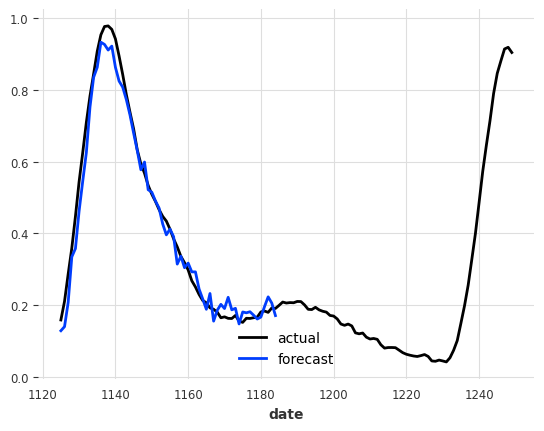

In [115]:
from darts.metrics.metrics import mae

def calculate_mae(prediction_list, target_list):
    for i in range(len(prediction_list)):
        print(mae(prediction_list[i], target_list[i]))

test_series[0].plot(label='actual')
prediction[0].plot(label='forecast', lw=2)
plt.legend()
plt.show()


In [118]:
np.mean(mae(test_series, prediction))

0.06905869683138298